# COMP90051 Project 2

In [28]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [29]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [54]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Qtminus1 = np.full(self.narms, Q0) #stores q value of each arm, initallized to infinity
        self.counts = np.zeros(self.narms) #stores number of times an arm is pulled, for each arm
        self.rewards = np.zeros(self.narms) #stores total rewards recieved by each arm
        
    def play(self, tround, context=None):
        
        #explore exploit with probability epsilon 
        eps, argmax = np.random.multinomial(1, [self.epsilon, 1-self.epsilon])
        
        if argmax == 1: #argmax is to choose the arm with highest Q(t-1) value
            possible_arm_index = np.argwhere(self.Qtminus1 == np.max(self.Qtminus1)) # index of the maximum q value
            possible_arm_index = possible_arm_index.flatten() # in the case we have more than two
            arm_index = np.random.choice(possible_arm_index) #tie breaking,  pick a miximising arm at random
            arm = arm_index + 1
        else:
            arm = int(np.random.uniform(1, self.narms+1)) #otherwise explore, randomly pick arm

        return arm
        
        
    def update(self, arm, reward, context=None):
        arm_index = arm - 1 #arm index needed to update counts, rewards and q value of the arm
        
        self.counts[arm_index] += 1
        self.rewards[arm_index] += reward
        
        self.Qtminus1[arm_index] = self.rewards[arm_index]/self.counts[arm_index] #calculates and updates q value
            

In [57]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.tround = int() # tround value initialised as int
        
        self.Qtminus1 = np.full(self.narms, Q0) #stores q value of each arm, initallized to infinity
        self.mu_hat = np.zeros(self.narms) #stores UCB mu hat from lectures, for each arm
        self.counts = np.zeros(self.narms) #stores number of times an arm is pulled, for each arm
        self.rewards = np.zeros(self.narms) #stores total rewards recieved by each arm
    
    def play(self, tround, context=None):
        possible_arm_index = np.argwhere(self.Qtminus1 == np.max(self.Qtminus1))  #choose the arm with highest Q(t-1) value
        possible_arm_index = possible_arm_index.flatten()
        arm_index = np.random.choice(possible_arm_index) #tie breaking, pick a miximising arm at random
        arm = arm_index + 1
        self.tround = tround # update tround to the provided nth round
        return arm
        
    def update(self, arm, reward, context=None):
        arm_index = arm - 1
        
        self.counts[arm_index] += 1
        self.rewards[arm_index] += reward
        
        self.mu_hat[arm_index] = self.rewards[arm_index]/self.counts[arm_index] 
        confidence = np.sqrt((self.rho*np.log(self.tround))/self.counts[arm_index]) # upper confidence
        self.Qtminus1[arm_index] = self.mu_hat[arm_index] + confidence # calculates the udated q-value for each arm
    

The cell below reads in the data

In [59]:
data = []

with open('dataset.txt') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split()
        data.append(line)
        
arms = [] # list containing all the arms from the data, as an interger
rewards = [] # list containing all the rewards from the data, as an interger
contexts_string = []
for line in data:
    arms.append(int(line[0]))
    rewards.append(int(line[1]))
    contexts_string.append(line[2:]) 

contexts = [] # list conataining all the containing all the contexts, each as an array
for line in contexts_string:
    line = list(map(int, line)) # convert the strings to int data type 
    line = np.array(line)
    line = np.reshape(line,(10,10))
    contexts.append((line))

contexts = np.array(contexts) # converting the contexts to an array

## 2. Off-Policy Evaluation

In [62]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    R_t = [] # list of rewards over all rounds/matching plays
    htminus1 = 0 # history of running 
    
    for k in range(len(arms)):
        arm = (arms[k])
        context_index = arm - 1 # context index to get the context of the arm from the contexts over all arms of the event

        mab_arm = mab.play(htminus1+1, contexts[k][context_index]) # pass in  h(t-1) + 1 as tround argument 

        if arm == mab_arm:
            R_t.append(rewards[k])
            mab.update(arm, rewards[k], contexts[k][context_index]) # update X(1)....X(k) context where k is number of arms  
            htminus1 += 1 # update the history of running only when there is a matching event 
    
        if htminus1 == nrounds:
#             print(sum(R_t)/htminus1)
            return np.array(R_t) #return a numpy array of the result of running when nrounds has been reached
        
#     print(sum(R_t)/htminus1)
    return np.array(R_t) #return a numpy array of the result of running


In [63]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2675


In [64]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.19625


## 3. Contextual Bandits

In [60]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        
        self.A_arm = np.zeros((self.narms, self.ndims, self.ndims)) # create for each arm, a 10*10 array, A(a) in paper
        self.b_arm = np.zeros((self.narms, self.ndims)) # create for each arm, an array of size 10, b(a) in paper
        
        self.p_arm = np.zeros(self.narms) # we store p value of each arm, at time t 
        self.theta_hat = np.zeros((self.narms, self.ndims)) # theta_hat store value of theta at each round, same size as b_arm
        
        for i in range(self.narms):
            self.A_arm[i] = np.identity(self.ndims) # intiate each array in A_arm as an identity matrix
                
    def play(self, tround, context):
        
        for index in range(self.narms):
            A_arm_inverse = np.linalg.inv(self.A_arm[index]) # inverse of A of arm 
            self.theta_hat[index]  = np.dot(A_arm_inverse, self.b_arm[index]) # calculate theta_hat for each arm 
            confidence = self.alpha * np.sqrt(np.linalg.multi_dot([context, A_arm_inverse, context.T])) #calculate confidence, using context and A(arm) inverse
            self.p_arm[index] = np.dot(self.theta_hat[index],context.T) + confidence # calculate p(arm) at time t 
        
        possible_arm_index = np.argwhere(self.p_arm == np.max(self.p_arm)) # select arm with highest p-value
        possible_arm_index = possible_arm_index.flatten()
        arm_index = np.random.choice(possible_arm_index) # tie breaking at random
        arm = arm_index + 1
        
        return arm   
    
    def update(self, arm, reward, context):
        arm_index = arm - 1
        self.A_arm[arm_index] = self.A_arm[arm_index] + np.dot(context, context.T) #updates the A_arm array for the arm
        self.b_arm[arm_index] = self.b_arm[arm_index] + np.dot(reward, context) # updates the b_arm array for the arm
    

In [61]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.30875


## 4. Evaluation
### 4.A.

mab1 is done
mab2 is done
mab3 is done


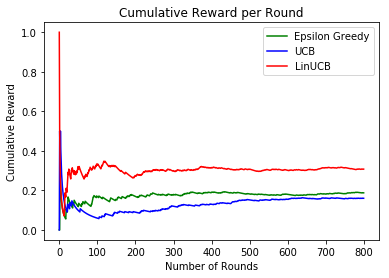

In [38]:
def get_per_round_cumulative_rewards(results): # calculates cumulative reward per round
    per_round_cumulative_rewards = []
    for i in range(0, len(results)):
        per_round_cumulative_rewards.append(sum(results[0:i+1])/(i+1)) # cumulative reward per round
    
    return per_round_cumulative_rewards

mab = LinUCB(10, 10, 1.0)
linUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
cumulative_linUCB = get_per_round_cumulative_rewards(linUCB)
print ("mab1 is done")

mab = UCB(10, 1.0)
ucb = offlineEvaluate(mab, arms, rewards, contexts, 800)
cumulative_ucb = get_per_round_cumulative_rewards(ucb)
print ("mab2 is done")

mab = EpsGreedy(10, 0.05)
epsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
cumulative_epsGreedy = get_per_round_cumulative_rewards(epsGreedy)
print ("mab3 is done")

plt.plot(cumulative_epsGreedy, label = "Epsilon Greedy", color = 'g') #plot cumulative reward for each mab
plt.plot(cumulative_ucb, label = "UCB", color = 'b')
plt.plot(cumulative_linUCB, label = "LinUCB", color = 'r')
plt.xlabel('Number of Rounds')
plt.title('Cumulative Reward per Round')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

### 4.B.

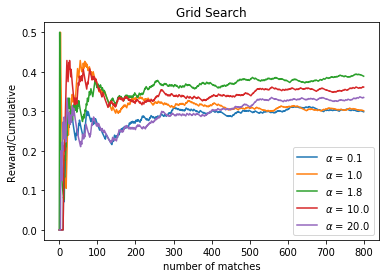

In [72]:
np.random.seed(0) 

alphas = [0.1, 1.0, 1.8, 10.0, 20.0] # all values of aplha

def grid_search(alphas): # grid search funtion
    results_list = []
    for alpha in alphas:
        mab = LinUCB(10, 10, alpha)
        results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        results_list.append(results_LinUCB)

    return results_list

results_list = grid_search(alphas)
    
for i, list_ in enumerate(results_list):
    alpha = alphas[i]
    per_round_cumulative_rewards = get_per_round_cumulative_rewards(list_)
    plt.plot(per_round_cumulative_rewards, label = r'${\alpha}$ = '+str(alpha)) # plots for each alpha
    
    
plt.xlabel('number of matches')
plt.ylabel('Reward/Cumulative')
plt.title('Grid Search')
plt.legend()
plt.show()